![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [27]:
import warnings
warnings.filterwarnings('ignore')
# Importación librerías
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
import multiprocessing

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold 
from xgboost import XGBClassifier, XGBRegressor

from flask import Flask
from flask_restx import Api, Resource, fields

import joblib
import os 

In [28]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

# Exploración

In [3]:
# Visualización datos de entrenamiento
dataTraining.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


In [4]:
# Visualización datos de test
dataTesting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Year     100000 non-null  int64 
 1   Mileage  100000 non-null  int64 
 2   State    100000 non-null  object
 3   Make     100000 non-null  object
 4   Model    100000 non-null  object
dtypes: int64(2), object(3)
memory usage: 4.6+ MB


In [8]:
len(dataTraining.State.value_counts())

51

In [16]:
n_jobs    = multiprocessing.cpu_count() - 2
n_jobs

6

In [9]:
len(dataTraining.Make.value_counts())

38

In [10]:
dataTraining.Model.value_counts()

Silverado          18085
Grand              12344
Sierra              8409
Accord              7357
F-1504WD            6684
                   ...  
PathfinderSE          53
Galant4dr             53
SLK-ClassSLK350       52
Monte                 48
RX-84dr               48
Name: Model, Length: 525, dtype: int64

# Prepración

In [5]:
X = dataTraining.drop(columns = ['Price'])
X_dummies = pd.get_dummies(X, columns=['State','Make','Model']) #Dummies de variables categóricas
X_dummies = X_dummies.drop(columns = ['Make_Freightliner'])
varx = list(X_dummies.columns)

Y = dataTraining['Price']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_dummies, Y, test_size=0.25, random_state = 0)

In [7]:
#Modelo base de XGBoost
XGBrEG = XGBRegressor()
XGBrEG.fit(Xtrain, Ytrain)

y_pred_XGB= XGBrEG.predict(Xtest)

RMSEXGBstandar = np.sqrt(np.average((y_pred_XGB-Ytest)**2))
print("RMSE XGBoost Regresor modelo base:" + str(RMSEXGBstandar))

RMSE XGBoost Regresor modelo base:4332.944818826237


## Calibración

### Learning rate (eta)

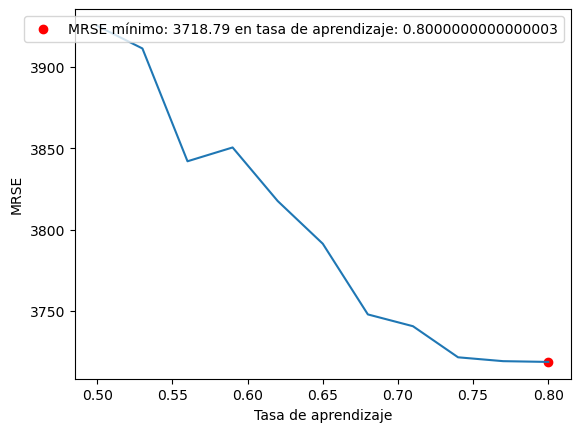

El valor mínimo de MRSE es: 3718.79 en tasa de aprendizaje : 0.8000000000000003


In [42]:
e_lr_XGB = np.arange(0.5, 0.81, 0.03)
MSRE_lr_XGB = []
MAE_lr_XGB = []

for rate in e_lr_XGB:
    
    clf_XGBc_lr = XGBRegressor(random_state = 42, learning_rate = rate, n_jobs = -1)
    
    clf_XGBc_lr.fit(Xtrain, Ytrain)
    y_pred_XGBc_lr = clf_XGBc_lr.predict(Xtest)
    
    MSRE_lr_XGB.append(np.sqrt(metrics.mean_squared_error(y_pred_XGBc_lr, Ytest)))
    MAE_lr_XGB.append(metrics.mean_absolute_error(y_pred_XGBc_lr, Ytest))

#Gráfica
plt.plot(e_lr_XGB, MSRE_lr_XGB)
plt.xlabel('Tasa de aprendizaje')
plt.ylabel('MRSE')

min_MRSE = min(MSRE_lr_XGB)
indice_min_MRSE = MSRE_lr_XGB.index(min_MRSE)
n_estimators_min_MRSE = e_lr_XGB[indice_min_MRSE]

plt.scatter(n_estimators_min_MRSE, min_MRSE, color='red', label=f'MRSE mínimo: {min_MRSE:.2f} en tasa de aprendizaje: {n_estimators_min_MRSE}')
plt.legend()

plt.show()

print(f"El valor mínimo de MRSE es: {min_MRSE:.2f} en tasa de aprendizaje : {n_estimators_min_MRSE}")

### Max depth Tree

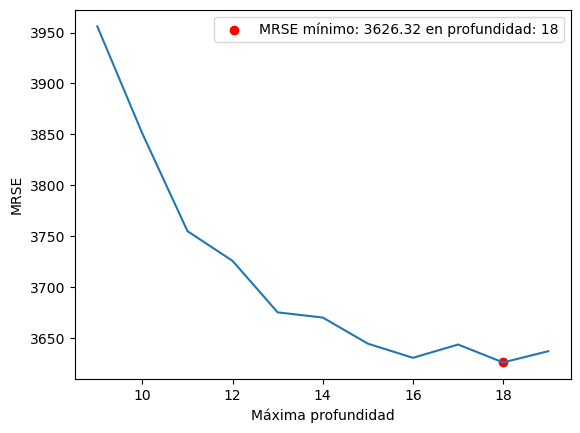

El valor mínimo de MRSE es: 3626.32 en profundidad : 18


In [49]:
e_lr_XGB = np.arange(9, 20, 1)
MSRE_lr_XGB = []
MAE_lr_XGB = []

for rate in e_lr_XGB:
    
    clf_XGBc_lr = XGBRegressor(random_state = 42, max_depth = rate, n_jobs = -1)
    
    clf_XGBc_lr.fit(Xtrain, Ytrain)
    y_pred_XGBc_lr = clf_XGBc_lr.predict(Xtest)
    
    MSRE_lr_XGB.append(np.sqrt(metrics.mean_squared_error(y_pred_XGBc_lr, Ytest)))
    MAE_lr_XGB.append(metrics.mean_absolute_error(y_pred_XGBc_lr, Ytest))

#Gráfica
plt.plot(e_lr_XGB, MSRE_lr_XGB)
plt.xlabel('Máxima profundidad')
plt.ylabel('MRSE')

min_MRSE = min(MSRE_lr_XGB)
indice_min_MRSE = MSRE_lr_XGB.index(min_MRSE)
n_estimators_min_MRSE = e_lr_XGB[indice_min_MRSE]

plt.scatter(n_estimators_min_MRSE, min_MRSE, color='red', label=f'MRSE mínimo: {min_MRSE:.2f} en profundidad: {n_estimators_min_MRSE}')
plt.legend()

plt.show()

print(f"El valor mínimo de MRSE es: {min_MRSE:.2f} en profundidad : {n_estimators_min_MRSE}")

### Muestras aleatorias por arbol

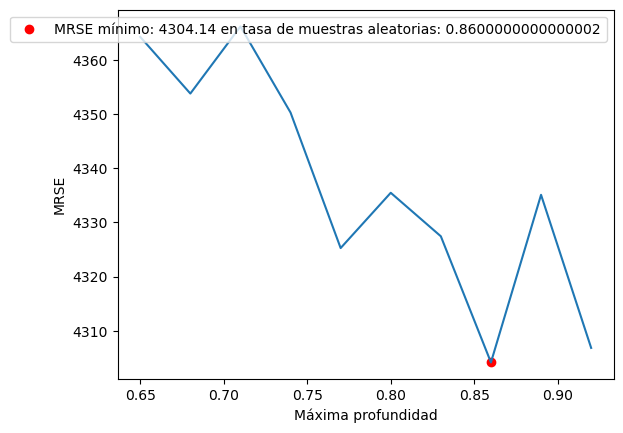

El valor mínimo de MRSE es: 4304.14 en tasa de muestras aleatorias : 0.8600000000000002


In [62]:
e_lr_XGB = np.arange(0.65, 0.95, 0.03)
MSRE_lr_XGB = []
MAE_lr_XGB = []

for rate in e_lr_XGB:
    
    clf_XGBc_lr = XGBRegressor(random_state = 42, colsample_bytree = rate, n_jobs = -1)
    
    clf_XGBc_lr.fit(Xtrain, Ytrain)
    y_pred_XGBc_lr = clf_XGBc_lr.predict(Xtest)
    
    MSRE_lr_XGB.append(np.sqrt(metrics.mean_squared_error(y_pred_XGBc_lr, Ytest)))
    MAE_lr_XGB.append(metrics.mean_absolute_error(y_pred_XGBc_lr, Ytest))

#Gráfica
plt.plot(e_lr_XGB, MSRE_lr_XGB)
plt.xlabel('tasa de muestras aleatorias')
plt.ylabel('MRSE')

min_MRSE = min(MSRE_lr_XGB)
indice_min_MRSE = MSRE_lr_XGB.index(min_MRSE)
n_estimators_min_MRSE = e_lr_XGB[indice_min_MRSE]

plt.scatter(n_estimators_min_MRSE, min_MRSE, color='red', label=f'MRSE mínimo: {min_MRSE:.2f} en tasa de muestras aleatorias: {n_estimators_min_MRSE}')
plt.legend()

plt.show()

print(f"El valor mínimo de MRSE es: {min_MRSE:.2f} en tasa de muestras aleatorias : {n_estimators_min_MRSE}")

### Muestras aleatorias por nivel

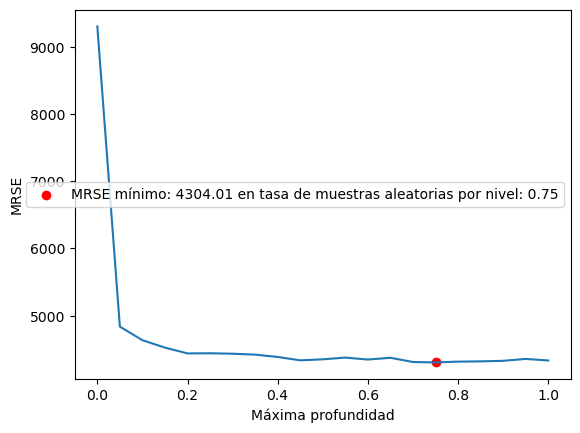

El valor mínimo de MRSE es: 4304.01 en tasa de muestras aleatorias por nivel: 0.75


In [64]:
e_lr_XGB = np.arange(0, 1.05, 0.05)
MSRE_lr_XGB = []
MAE_lr_XGB = []

for rate in e_lr_XGB:
    
    clf_XGBc_lr = XGBRegressor(random_state = 42, colsample_bylevel = rate, n_jobs = -1)
    
    clf_XGBc_lr.fit(Xtrain, Ytrain)
    y_pred_XGBc_lr = clf_XGBc_lr.predict(Xtest)
    
    MSRE_lr_XGB.append(np.sqrt(metrics.mean_squared_error(y_pred_XGBc_lr, Ytest)))
    MAE_lr_XGB.append(metrics.mean_absolute_error(y_pred_XGBc_lr, Ytest))

#Gráfica
plt.plot(e_lr_XGB, MSRE_lr_XGB)
plt.xlabel('tasa de muestras aleatorias por nivel')
plt.ylabel('MRSE')

min_MRSE = min(MSRE_lr_XGB)
indice_min_MRSE = MSRE_lr_XGB.index(min_MRSE)
n_estimators_min_MRSE = e_lr_XGB[indice_min_MRSE]

plt.scatter(n_estimators_min_MRSE, min_MRSE, color='red', label=f'MRSE mínimo: {min_MRSE:.2f} en tasa de muestras aleatorias por nivel: {n_estimators_min_MRSE}')
plt.legend()

plt.show()

print(f"El valor mínimo de MRSE es: {min_MRSE:.2f} en tasa de muestras aleatorias por nivel: {n_estimators_min_MRSE}")

Calibración final por combinación entre # de arboles y tasa de aprendizaje

------------------------------------------
Test learning rate para 300 arboles
------------------------------------------


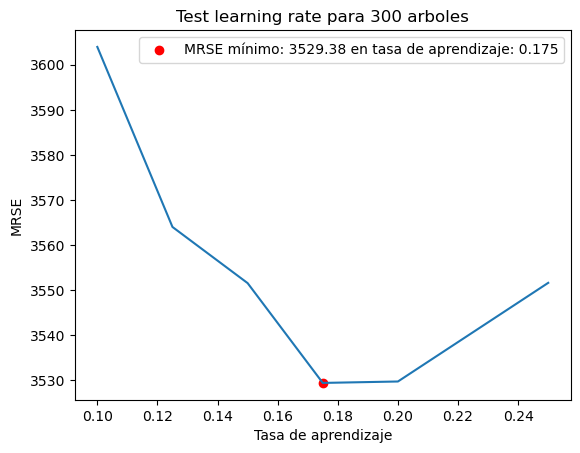

El valor mínimo de MRSE es: 3529.38 en tasa de aprendizaje : 0.175
------------------------------------------
Test learning rate para 400 arboles
------------------------------------------


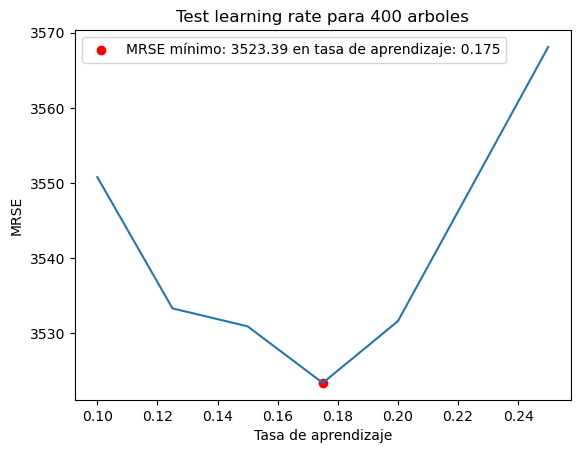

El valor mínimo de MRSE es: 3523.39 en tasa de aprendizaje : 0.175
------------------------------------------
Test learning rate para 500 arboles
------------------------------------------


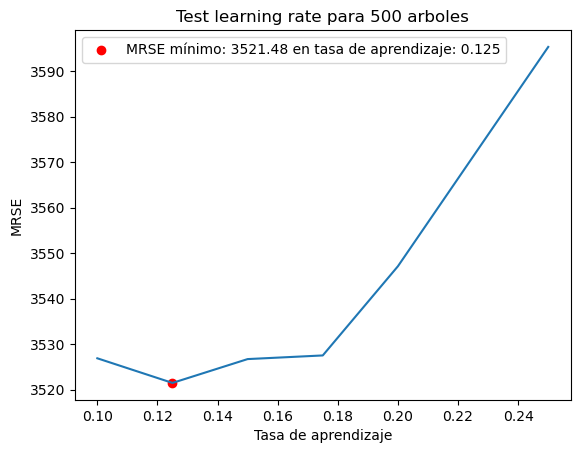

El valor mínimo de MRSE es: 3521.48 en tasa de aprendizaje : 0.125


In [ ]:
e_lr_XGB = [0.1, 0.125, 0.15, 0.175, 0.2, 0.25]
arboles_XGB = [300,400,500]

for i in range(0,len(arboles_XGB)):
    print("------------------------------------------")
    print("Test learning rate para "+str(arboles_XGB[i]) + " arboles")
    print("------------------------------------------")

    MSRE_lr_XGB = []

    for rate in e_lr_XGB:
        
        clf_XGBc_lr = XGBRegressor( learning_rate = rate, #tasa de aprendizaje
                                    n_estimators = arboles_XGB[i], #Número de estimadores
                                    max_depth = 16, #Profundidad maxima por arbol
                                    reg_lambda = 1, #Termino de regularización L2 (Lasso)
                                    colsample_bytree = 0.85, #Muestra aleatoria por arbol
                                    colsample_bylevel = 0.75, #Muestra aleatoria por división del arbol
                                    n_jobs = multiprocessing.cpu_count() - 1, #Procesadores a utilizar
                                    random_state = 123 #raiz de seleccion al azar de muestra
                                    )
        
        clf_XGBc_lr.fit(Xtrain, Ytrain)
        y_pred_XGBc_lr = clf_XGBc_lr.predict(Xtest)
        
        MSRE_lr_XGB.append(np.sqrt(metrics.mean_squared_error(y_pred_XGBc_lr, Ytest)))

    #Gráfica
    plt.plot(e_lr_XGB, MSRE_lr_XGB)
    plt.xlabel('Tasa de aprendizaje')
    plt.ylabel('MRSE')

    min_MRSE = min(MSRE_lr_XGB)
    indice_min_MRSE = MSRE_lr_XGB.index(min_MRSE)
    n_estimators_min_MRSE = e_lr_XGB[indice_min_MRSE]

    plt.scatter(n_estimators_min_MRSE, min_MRSE, color='red', label=f'MRSE mínimo: {min_MRSE:.2f} en tasa de aprendizaje: {n_estimators_min_MRSE}')
    plt.legend()
    plt.title("Test learning rate para "+str(arboles_XGB[i])+" arboles")

    plt.show()

    print(f"El valor mínimo de MRSE es: {min_MRSE:.2f} en tasa de aprendizaje : {n_estimators_min_MRSE}")

## Modelo Optimo

In [34]:
#Modelo optimo de XGBoost
XGBROptimo = XGBRegressor(learning_rate = 0.125, 
                          max_depth = 16, 
                          reg_lambda = 1, 
                          colsample_bytree = 0.85,
                          colsample_bylevel = 0.3, 
                          n_estimators = 600,
                          n_jobs = multiprocessing.cpu_count() - 1,
                          random_state = 123)
XGBROptimo.fit(Xtrain, Ytrain)

y_pred_XGB= XGBROptimo.predict(Xtest)

RMSEXGBoptimo = np.sqrt(np.average((y_pred_XGB-Ytest)**2))
print("RMSE XGBoost Regresor modelo optimo:" + str(RMSEXGBoptimo))

#Se guarda el modelo como pkl
joblib.dump(XGBROptimo, r"C:\Users\SANTIAGO\MIAD\2-ML y PLN\Git\MIAD_ML_NLP_2023\Semana 3\Competition deployment\XGB_Car_Price.pkl", compress=3)

RMSE XGBoost Regresor modelo optimo:3487.5172151526967


['C:\\Users\\SANTIAGO\\MIAD\\2-ML y PLN\\Git\\MIAD_ML_NLP_2023\\Semana 3\\Competition deployment\\XGB_Car_Price.pkl']

# Predicción

In [14]:
#Predicción
X_test_dummies = pd.get_dummies(dataTesting, columns=['State','Make','Model']) #Dummies de variables categóricas
resp_final = XGBROptimo.predict(X = X_test_dummies)
y_pred_final = pd.DataFrame(resp_final, index=X_test_dummies.index, columns=['Price'])

# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred_final.to_csv(r"C:\Users\SANTIAGO\MIAD\2-ML y PLN\Git\MIAD_ML_NLP_2023\Semana 3\Competition deployment\test_submission_Santiago2.csv", index_label='ID')

In [43]:
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


### Función de predicción por registros nuevos


Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

In [39]:
def pred_price(info):
    input = info
    #Importar datos de test para comparar campos
    dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)
    
    #Para revisión de inputs
    States = list(dataTesting['State'].drop_duplicates())
    Make = list(dataTesting['Make'].drop_duplicates())
    Model = list(dataTesting['Model'].drop_duplicates())

    if type(input) != list:
        print("No se ingresó una lista")
    elif len(input) != 5:
        print("No se ingresó el número específico de parámetros")
    elif info[2] not in States:
        print("No se infgresó un Estado válido en la posición 3")
    elif info[3] not in Make:
        print("No se infgresó un fabricante válido en la posición 3")
    elif info[4] not in Model:
        print("No se infgresó un Modelo válido en la posición 3")
    else:
        
        X_test_dummies_orig = pd.get_dummies(dataTesting, columns=['State','Make','Model'])
        X_test_dummies_orig = X_test_dummies_orig[X_test_dummies_orig['Year']>2030].transpose()

        #Construcción estructura en dummies
        dict_input = {'Year':input[0],'Mileage':input[1],'State' :input[2],'Make':input[3],'Model':input[4]}
        inputDf = pd.DataFrame(dict_input, index = [0])
        X_test_dummies = pd.get_dummies(inputDf, columns=['State','Make','Model']).transpose() #Dummies de variables categóricas

        #Construcción nueva observación
        New_Obs = pd.merge(left=X_test_dummies_orig,
                        right=X_test_dummies,
                        right_index=True,
                        left_index=True,
                        how='left')

        New_Obs.fillna(0, inplace=True)
        New_Obs = New_Obs.transpose()

        #Importando el clasificador guardado
        clf = joblib.load(r"C:\Users\SANTIAGO\MIAD\2-ML y PLN\Git\MIAD_ML_NLP_2023\Semana 3\Competition deployment\XGB_Car_Price.pkl") 

        #Predicción del modelo
        pred_final = clf.predict(X = New_Obs)

        return round(float(pred_final),2)

# Guardar modelo en flask


In [40]:
# Definición aplicación Flask
app = Flask(__name__)

# Definición API Flask
api = Api(
    app, 
    version='1.0', 
    title='Car Price Prediction - Group 25',
    description='Car price prediction API, group 25 ML and NLP')

ns = api.namespace('predict', 
     description='Car price Estimation')

# Definición argumentos o parámetros de la API
parser = api.parser()
parser.add_argument(
    'Year', 
    type=int, 
    required=True, 
    help='Year of manufacture of the car', 
    location='args')

parser.add_argument(
    'Mileage', 
    type=float, 
    required=True, 
    help='Mileage of the car', 
    location='args')

parser.add_argument(
    'State', 
    type=str, 
    required=True, 
    help='State in which the car is being sold (add a space before argument)', 
    location='args')

parser.add_argument(
    'Brand', 
    type=str, 
    required=True, 
    help='Brand of the car', 
    location='args')

parser.add_argument(
    'Model', 
    type=str, 
    required=True, 
    help='Model of the car', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.Float,
})

In [41]:
# Definición de la clase para disponibilización
@ns.route('/')
class PricePredApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "result": pred_price([args['Year'],args['Mileage'],args['State'],args['Brand'],args['Model']])
        }, 200

In [44]:
# Ejecución de la aplicación que disponibiliza el modelo de manera local en el puerto 5000
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.3:5000
Press CTRL+C to quit
127.0.0.1 - - [24/Apr/2024 20:59:58] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2024 20:59:58] "GET /swaggerui/droid-sans.css HTTP/1.1" 304 -
127.0.0.1 - - [24/Apr/2024 20:59:58] "GET /swaggerui/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [24/Apr/2024 20:59:58] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [24/Apr/2024 20:59:58] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [24/Apr/2024 20:59:59] "GET /swagger.json HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2024 21:00:43] "GET /predict/?Year=2010&Mileage=36298&State=%20WA&Brand=Nissan&Model=MuranoAWD HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2024 21:01:30] "GET /predict/?Year=2010&Mileage=36298&State=%20WA&Brand=Nissan&Model=MuranoAWD HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2024 21:01:30] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [24/Apr/2024 21:01:48] "G